<a href="https://colab.research.google.com/github/deepakjayakumar/TensorFlow_project_1/blob/main/god_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1. Problem

Identifying the breed of the dog in the giiven photo

## 2. Data

The data was taken from Kaggle dog breed database

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evealuation is a file with prediction probabilities of each dog breed of each test image

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so its probabaly best we use deep learning
* There are 120 breeds of dog (Multi class classification)
* There are 10,000+ images in train set (these images have labels)
* There are 10,000+ images in the test set (these images dont have labels and we will want to predict it)

In [10]:
# Unzip the uploaded data in Google cloud
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get your workspace ready

In [11]:
# Import tensorflow in colab
import tensorflow as tf
print('Tensor version: ',tf.__version__)

Tensor version:  2.17.0


In [12]:
import tensorflow_hub as hub
print("TF hub version : ", hub.__version__)

# Check for GPU availability
print("GPU"," availabile" if tf.config.list_physical_devices("GPU") else "not available")

TF hub version :  0.16.1
GPU  availabile


# Getting our data ready

With all machine learning models our data should be in numeric. So we will be turining our images into tensors (numerical representation)

Lets start by acccesing our data anc checking out the labels

In [13]:
# check out the data of our labels
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")

In [14]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,fff43b07992508bc822f33d8ffd902ae,scottish_deerhound
freq,1,126


In [15]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

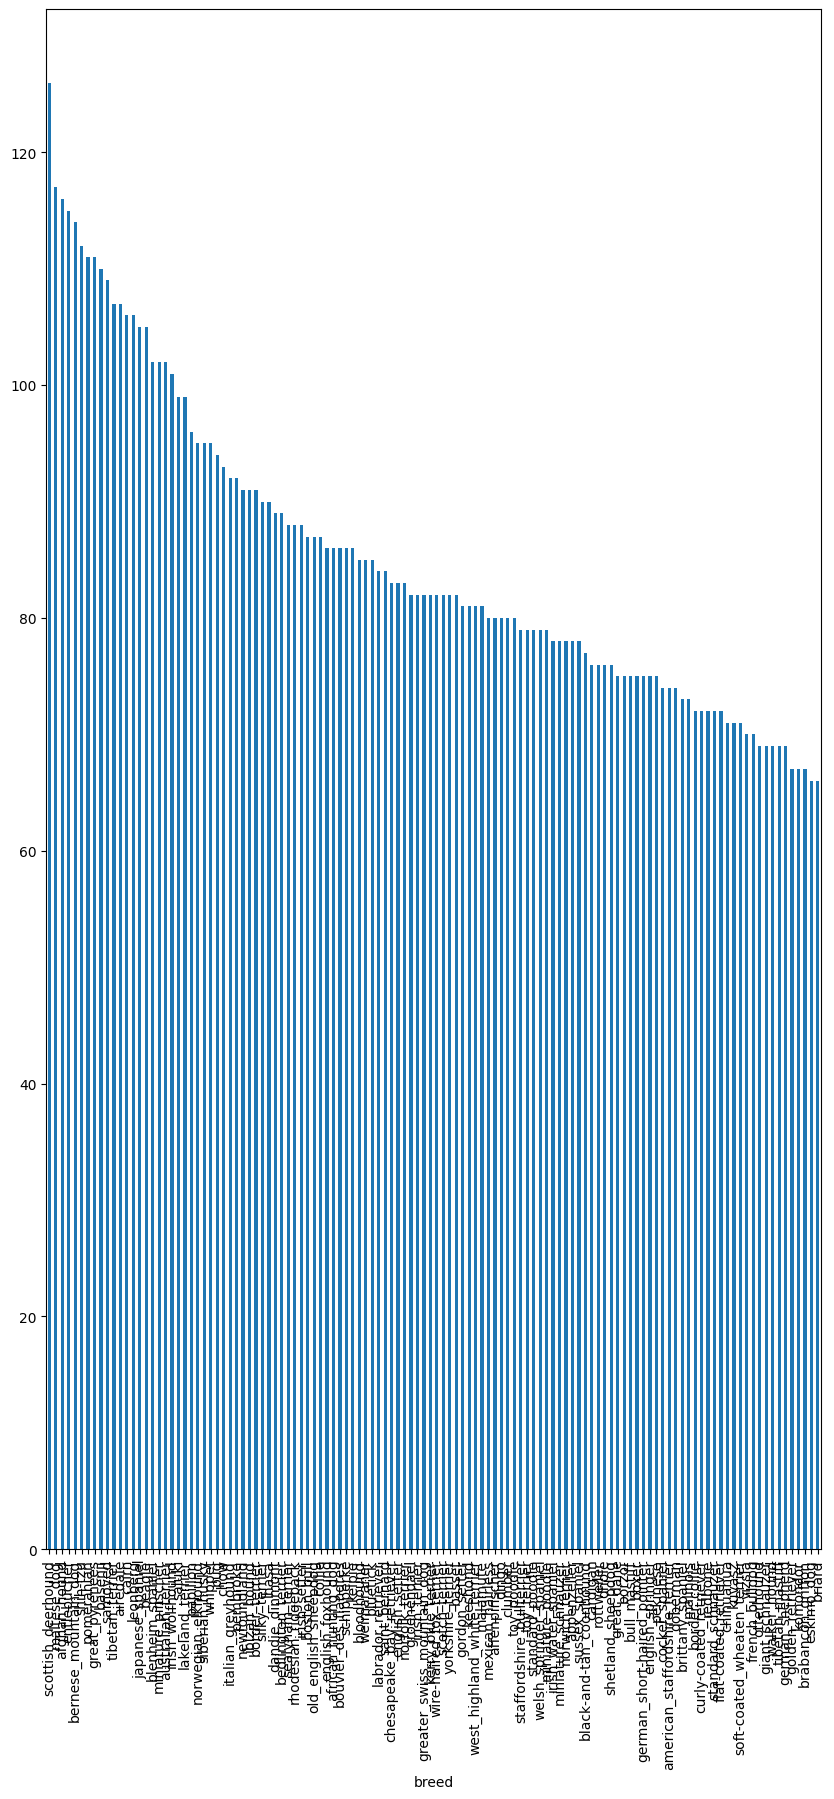

In [20]:
# How many counts are there with each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(10,20))

In [24]:
labels_csv["breed"].value_counts().median()

82.0